In this notebook we analyze data using Apache Spark instead of pandas with raw Python. Furthermore, the CSVs are parsed manually, with no util plugin.

# Data load and processing

Spark itself supports globbing when specifying input files, but it loads them in an unpredictable order. For our case, it's better to concatenate the files in filename order, so first we get the sorted list of filenames and then we pass it to the loader.

In [1]:
PRINT_THINGS = True
USING_CLUSTER = False # Uses HDFS and Spark 1.6
AS_A_SERVER_SCRIPT = False # No GUI, implies USING_CLUSTER = True

MAX_RM_EVS_FIGURES = 3 # It may not be necessary to generate the RM evolution for all the threads
PRINT_ALL_KS = False # If False, it only generates a figure for the best K in clustering

filenames = []
if USING_CLUSTER: # HDFS
    import subprocess
    command = 'hdfs dfs -ls "*.csv" | sed "s/  */ /g" | cut -d\  -f8'
    p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    filenames = [line.replace("\n", "") for line in p.stdout.readlines()]
    retval = p.wait()
else:
    import glob
    filenames = glob.glob("03-05-2017_14-44-00.csv")
filenames.sort()

# Some stuff that the notebook does for us and needs to be done when executed as a script
if AS_A_SERVER_SCRIPT:
    from pyspark import SparkContext, SQLContext
    sc = SparkContext()
    spark = SQLContext(sc) # To use "toDF"

# Loads files as a single raw text RDD
raw = sc.textFile(','.join(filenames))

# Parses CSV format
FIELD_SEPARATOR=","
aux = raw.map(lambda x: x.split(FIELD_SEPARATOR)) # Splits by FIELD_SEPARATOR
header = aux.take(1)[0] # We extract the header
csv = aux.filter(lambda x: x[0] != "TYPE") # We filter the header

# Gets insts samples only
idx = header.index("TYPE")
ins = csv.filter(lambda x: x[idx] == "I")

# Converts to DF with correct column names
df = ins.toDF(header)

# Filters and casts columns
df = df.selectExpr("TYPE","PID","TID","cast(TIME as bigint) as TIME","CPU", \
    "cast(TIME_E as bigint) as TIME_E","cast(INST as bigint) as INST","cast(REQ_DR as bigint) as REQ_DR")

# Unique PIDs, used later
pids = [r["PID"] for r in df.select("PID").distinct().collect()]

if PRINT_THINGS:
    df.show()

+----+-----+-----+----------------+---+------------+-------------+-----------+
|TYPE|  PID|  TID|            TIME|CPU|      TIME_E|         INST|     REQ_DR|
+----+-----+-----+----------------+---+------------+-------------+-----------+
|   I|31568|31568|4680103905126434|  0|587385836162|1277400000036|17537812345|
|   I|31568|31568|4680103949227776|  0|587429937854|1277400000036|17537812345|
|   I|31568|31568|4680103979831212|  0|587460541524|1277400000036|17537812345|
|   I|31568|31568|4680103996796957|  0|587477507480|1277400000036|17537812345|
|   I|31568|31568|4680104013759837|  0|587494470124|1277400000036|17537812345|
|   I|31568|31568|4680104042746864|  0|587523456799|1277400000036|17537812345|
|   I|31568|31568|4680104087244589|  0|587567954537|1277400000036|17537812345|
|   I|31568|31568|4680104104761791|  0|587585471266|1277400000036|17537812345|
|   I|31568|31568|4680104121718892|  0|587602428560|1277400000036|17537812345|
|   I|31568|31568|4680104138606107|  0|587619315723|

No map-reduce functions in Dataframe... A possible solution could be using groupBy and a UDAF (User Defined Aggregate Function) instead, but the later one isn't supported in PySpark yet (https://issues.apache.org/jira/browse/SPARK-10915). Another possible solution is getting the RDD associated to the DF and operate with it.

In [2]:
newrdd = df.rdd
newrdd.cache()
SYS_CACHE_LINE_SIZE = 64

from pyspark.sql import Row
from operator import attrgetter # Sorting is faster by using this module

# Mapper
def group_cpu(r):
    return (r["CPU"], [r])

# Reducer
def create_list(r1, r2):
    return r1+r2

# Second mapper
def create_increments(r):
    cpu = r[0]
    samples = r[1]
    
    # Previous sorting seems necessary
    samples.sort(key=attrgetter("TIME"))
    
    first_sample = samples[0]

    temp_inst = last_inst = first_sample["INST"]
    temp_req_dr = last_req_dr = first_sample["REQ_DR"]
    temp_elapsed = last_elapsed = first_sample["TIME_E"]

    # Sets first sample values to 0
    d = first_sample.asDict()
    d.pop("TYPE", None) # No longer necessary
    d.pop("CPU", None) # No longer necessary
    d["gis"] = temp_inst / float(temp_elapsed)
    d["oi"] = temp_inst / float(temp_req_dr*SYS_CACHE_LINE_SIZE)
    d["INST"] = 0
    d["REQ_DR"] = 0
    d["TIME_E"] = 0
    newr = Row(**d)
    samples[0] = newr
    
    # Calculates increments for the rest of the cases
    for i, s in enumerate(samples[1:], 1):
        temp_inst = s["INST"]
        temp_req_dr = s["REQ_DR"]
        temp_elapsed = s["TIME_E"]
        
        d = s.asDict()
        d.pop("TYPE", None)
        d.pop("CPU", None)
        d["INST"] = temp_inst - last_inst
        d["REQ_DR"] = temp_req_dr - last_req_dr
        d["TIME_E"] = temp_elapsed - last_elapsed
        d["gis"] = temp_inst / float(temp_elapsed) # elapsed comes in microseconds, so it already implies a (/ 10^9)
        d["oi"] =  temp_inst / float(temp_req_dr*SYS_CACHE_LINE_SIZE)
        newr = Row(**d)
        samples[i] = newr

        last_inst = temp_inst
        last_req_dr = temp_req_dr
        last_elapsed = temp_elapsed

    return samples

data_incr = newrdd.map(group_cpu).reduceByKey(create_list).flatMap(create_increments)
data_incr.cache()

if PRINT_THINGS:
    print data_incr.take(5)

[Row(INST=0, PID=u'31462', REQ_DR=0, TID=u'31462', TIME=4680107186891639, TIME_E=0, gis=0.022178324714668293, oi=0.8676139222403153), Row(INST=0, PID=u'31462', REQ_DR=0, TID=u'31462', TIME=4680107194379993, TIME_E=7488753, gis=0.022178043530944273, oi=0.8676139222403153), Row(INST=0, PID=u'31462', REQ_DR=0, TID=u'31462', TIME=4680107201713488, TIME_E=7333602, gis=0.02217776817965742, oi=0.8676139222403153), Row(INST=0, PID=u'31462', REQ_DR=0, TID=u'31462', TIME=4680107208896904, TIME_E=7182769, gis=0.022177498498253574, oi=0.8676139222403153), Row(INST=0, PID=u'31462', REQ_DR=0, TID=u'31462', TIME=4680107216554691, TIME_E=7658249, gis=0.022177210971889884, oi=0.8676139222403153)]


## Aggregation
It will be done exactly the same as the raw Python case: grouping by TID (map) and then adding all the fields involved in the final computation (`INST`, `TIME_E` and `REQ_DR`) (reduce). Then, the final divisions are done by an additional mapper.

In [3]:
# Mapper
def group_tid(r):
    return (r["TID"], [r])

# Reducer
def add_data(r1, r2):
    r1v = r1
    r2v = r2
    
    if isinstance(r1, list):
        r1v = r1[0]
    if isinstance(r2, list):
        r2v = r2[0]
    
    # May not be an accurate way to get the aggregated result
    inst = r1v["INST"] + r2v["INST"]
    time_e = r1v["TIME_E"] + r2v["TIME_E"]
    req_dr = r1v["REQ_DR"] + r2v["REQ_DR"]
    
    return Row(INST = inst, TIME_E = time_e, REQ_DR = req_dr)

def final_divs(kv):
    k = kv[0] # TID
    v = kv[1] # Sample
    
    oiv = v["INST"] / float(v["REQ_DR"]*SYS_CACHE_LINE_SIZE)
    gisv = v["INST"] / float(v["TIME_E"])
    
    return Row(tid = k, oi = oiv, gis = gisv)

# Filter is for discarding TIDs with only one sample, which are not of interest
agg = data_incr.map(group_tid).reduceByKey(add_data).filter(lambda x: len(x[1])>1 and x[1]["REQ_DR"] != 0).map(final_divs)
agg.cache()

if PRINT_THINGS:
    print agg.take(5)

[Row(gis=6.155832158106812, oi=6.622054001500927, tid=u'43112'), Row(gis=0.0052960104976852536, oi=7.19364425439242, tid=u'32462'), Row(gis=0.0012344667068368283, oi=1.2796426101352614, tid=u'1065'), Row(gis=5.3652822447528115, oi=0.8806206392975569, tid=u'31462'), Row(gis=2.1149907865022377, oi=1.117887639206904, tid=u'31568')]


## Optional data dumping

In [4]:
DUMP_INCR = False
DUMP_AGG = False

# Writes and concatenates some results. It was done to compare with increment calculation without Spark
if DUMP_INCR:
    auxdf = data_incr.sortBy(lambda x: x["TIME"]).toDF()
    auxdf.select("PID","TID","TIME","TIME_E","INST","REQ_DR").write.csv("results", header=True)
    if AS_A_SERVER_SCRIPT: # No IPython magic
        subprocess.call("cat results/part-r-0000* > incr_spark.csv && rm -r results", shell=True)
    else:
        !cat results/part-r-0000* > incr_spark.csv && rm -r results
        
if DUMP_AGG:
    agg.toDF().write.csv("results", header=True)
    if AS_A_SERVER_SCRIPT: # No IPython magic
        subprocess.call("cat results/part-r-0000* > agg_spark.csv && rm -r results", shell=True)
    else:
        !cat results/part-r-0000* > agg_spark.csv && rm -r results

# Plotting

In [5]:
# Sets up the environment
import matplotlib.pyplot as plt
if AS_A_SERVER_SCRIPT:
    plt.switch_backend("agg") # Necessary when a GUI does not exists
else:
    %matplotlib inline
import matplotlib.patches as mpatches

## Plot modular functions

In [6]:
ROOFS = [
    # Based on spec sheets, for each core
    {
        "max_ginsts": 4*1.8,
        "max_throughput": 1.85,
        "line_colour": "r"
    },
    # Given by "Empirical Roofline Tool"
    {
        "max_ginsts": 10,
        "max_throughput": 0.9,
        "line_colour": "b"
    }
]

def draw_roof(r):
    max_g = r["max_ginsts"]
    max_t = r["max_throughput"]
    c = r["line_colour"]
    
    # Straight line: x varies from "max_throughput" to INF, while y ("max_throughput") does not vary
    r_x = [max_t, 100]
    r_y = [max_g, max_g]
    plt.plot(r_x, r_y, c)
    
    # Line with slope: x varies from 0 to "max_throughput", y varies from 0 to "max_ginsts"
    r_x = [0, max_t]
    r_y = [0, max_g]
    plt.plot(r_x, r_y, c)
    
def draw_roofs():
    for r in ROOFS:
        draw_roof(r)

# Plots data in a scatter
def plot_data(x, y, labels=[], colors=None, marks = [], legend=None, log_scale=[], \
              xmin=None, ymin=None, xmax=None, ymax=None, circles=[], filename = "fig.png"):
    axs = plt.gca()
    
    plt.scatter(x, y, c = colors, linewidth = 0, edgecolor="", s = 100) # Main call
    plt.gcf().set_size_inches(16.8, 10.5)
    
    if "y" in log_scale:
        axs.set_yscale("log", basey=2)
    if "x" in log_scale:
        axs.set_xscale("log", basex=2)
    axs.set_xlabel("Operational intensity (Insts/byte)", fontsize=20)
    axs.set_ylabel("GInsts/s", fontsize=20)
    
    # Ticks font size
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    
    # For clustering plotting (as circles)
    for circle in circles:
        axs.add_artist(circle)
        
    # For clustering plotting (as marks)
    for m in marks:
        plt.plot(m[0], m[1], "x", c = m[2], markersize = 30)

    # Adds text to point
    for i, txt in enumerate(labels):
        axs.annotate(txt, (x[i], y[i]), xytext = (0, -20), size = 8,
            textcoords = "offset points", ha = "center", va = "bottom",
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5)            
        )
    
    draw_roofs()
    
    if xmin is None:
        xmin = 0.9*min(x)
    if xmax is None:
        xmax = 1.02*max(x)
    if ymin is None:
        ymin = 0.9*min(y)
    if ymax is None:
        reference = min( max(y), ROOFS[0]["max_ginsts"] )
        ymax = 1.02*reference
        
    axs.set_xlim(xmin, xmax)
    axs.set_ylim(ymin, ymax)
    
    if legend is not None:
        plt.legend(handles=legend, loc="upper left")
    
    # Shows everything
    plt.show()
    
    if AS_A_SERVER_SCRIPT:
        plt.savefig(filename, bbox_inches="tight")
        plt.gcf().clear()
    
# We associate PID to random color, trying not to use similar colours
def associate_colors_to_pids(pids, tol = 50):
    from random import randint
    
    colors = {}
    for pid in pids:
        
        # Loop where we evalue the similarity between the colors
        discard = True
        while discard == True:
            rand_col = "#" + '%06X' % randint(0, 0xFFFFF0)

            discard = False
            for hex_str in colors.values():

                # We extract red, green and blue individual values
                v1 = [int(rand_col[1+i: 3+i], 16) for i in range(0,6,2)]
                v2 = [int(hex_str[1+i: 3+i], 16) for i in range(0,6,2)]
                
                # We define their difference by adding the absolute subtract of their parts
                diff = sum(map(lambda v1, v2: abs(v1-v2), v1, v2))
                
                if diff < tol:
                    discard = True
                    break
                    
        colors[pid] = rand_col
        
    return colors

# We associate PID to random color
def associate_colors_to_pids_old(pids, tol = 0):
    from random import randint
    
    colors = {}
    for pid in pids:
        colors[pid] = "#" + '%06X' % randint(0, 0xFFFFFF)
    
    return colors
    
def get_rand_colors_to_plot(pids, tid_pmap, tid_list):
    c_map = associate_colors_to_pids(pids) # Maps PID->color

    # We will create tid_cmap (TID->color) using tid_pmap (TID->PID) and c_map (PID->color)
    tid_cmap = {}
    for tid, pid in tid_pmap.iteritems():
        color = c_map[pid]
        tid_cmap[tid] = color

    # Final colors and legend array to be passed to the plot function
    point_colors = [tid_cmap[tid] for tid in tid_list]

    # Useful for legend plotting
    legend = [mpatches.Patch(color=c, label=p) for p, c in c_map.iteritems()]
    
    return point_colors, legend

## Additional data processing and function calls

In [7]:
tids = []
ois = []
giss = []
vectors = [] # For clustering

# Extracts data
for r in agg.collect():
    tids.append(r["tid"])
    ois.append(r["oi"])
    giss.append(r["gis"])
    vectors.append([r["gis"], r["oi"]])

# Simple mapred job to get PID from every TID
tid_map = newrdd.map(lambda r: (r["TID"], r["PID"])).reduceByKey(lambda x, y: x).collectAsMap()

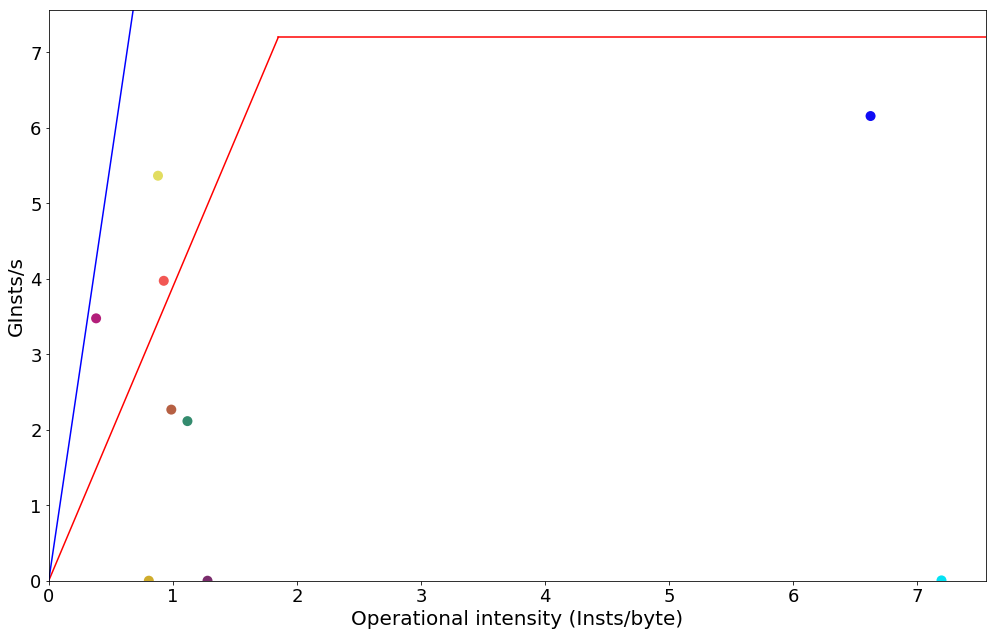

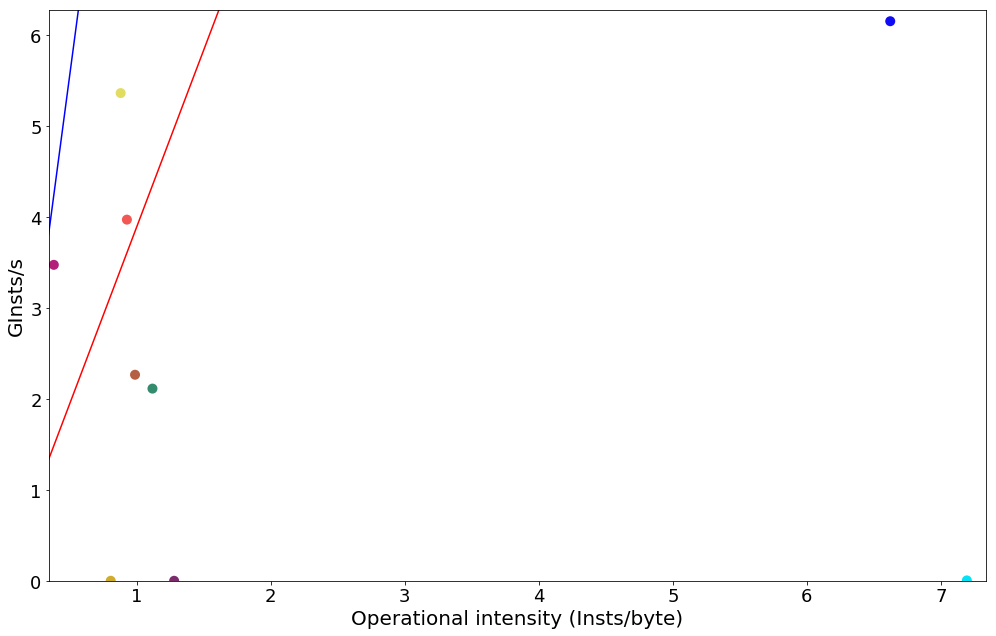

In [8]:
# Now, let's plot with colors!
c, l = get_rand_colors_to_plot(pids, tid_map, tids)
plot_data(ois, giss, colors=c, xmin = 0.0, xmax = max(1.05*max(ois),2*ROOFS[0]["max_throughput"]), \
          ymin = 0.0, ymax = 1.05*ROOFS[0]["max_ginsts"], filename="aggplot.png")
plot_data(ois, giss, colors=c, filename="aggplot_zoom.png")

## Time plot

We will do some stuff to plot, for each PID (different lines), the evolution of instructions over time. The first thing to take into account is that sample timestamp does not match actual system timestamp. We have to subtract the minimum timestamp to each sample and then we can add a reference timestamp, which we don't have in this case. Then, we do some calculations to know which (and how many) custom X tick labels to use.

In [9]:
inv_micr = 10 ** -9 # Precalculated
total_min = newrdd.min(key=lambda r: r["TIME"])["TIME"] # First timestamp. Reference
total_max = newrdd.max(key=lambda r: r["TIME"])["TIME"] # Simply to know how many hours/minutes to plot
base_timestamp = 0 # Execution script timestamp. 0 if not known
value_to_add = -total_min + base_timestamp
diff_secs = (total_max - total_min) * inv_micr

TIME_MAGS = [
    {
        "label": "day",
        "factor": 60*60*24,
    },
    {
        "label": "h",
        "factor": 60*60,
    },
    {
        "label": "min",
        "factor": 60,
    },
    {
        "label": "sec",
        "factor": 1,
    },
]

# Gets the most fitting magnitude: the biggest that allows to show at least one label
mag_to_use = None
mag_value = None
for i, elm in enumerate(TIME_MAGS):
    mag_value = int(diff_secs / elm["factor"])
    if mag_value != 0:
        mag_to_use = elm
        break

# Minute ticks
custom_xtick_data = {}
custom_xtick_data["values"] = [mag_to_use["factor"]*m for m in range(mag_value+1)]
custom_xtick_data["labels"] = [str(m) + " " + mag_to_use["label"] for m in range(mag_value+1)]
custom_xtick_data["labels"][0] = "Begin"

In [10]:
def time_increments(r):
    d = r.asDict()
    d["TIME"] = (d["TIME"] + value_to_add) * inv_micr
    return Row(**d)

#time_incr = newrdd.map(time_increments) # Makes "increments" for timestamp
time_incr = data_incr.sortBy(attrgetter("TIME")).map(time_increments) # Makes "increments" for timestamp
time_incr.cache()

if PRINT_THINGS:
    print time_incr.take(5)

[Row(INST=0, PID=u'31462', REQ_DR=0, TID=u'31462', TIME=0.0, TIME_E=0, gis=0.8348168611097906, oi=0.936398937723963), Row(INST=0, PID=u'31194', REQ_DR=0, TID=u'31194', TIME=0.0046277290000000006, TIME_E=0, gis=3.5591154772991627, oi=0.38194906220094305), Row(INST=0, PID=u'43112', REQ_DR=0, TID=u'43112', TIME=0.005647350000000001, TIME_E=0, gis=6.236337408587062, oi=6.620504168994245), Row(INST=0, PID=u'31568', REQ_DR=0, TID=u'31568', TIME=0.011250444, TIME_E=0, gis=2.1747204671848697, oi=1.138076665887743), Row(INST=0, PID=u'31462', REQ_DR=0, TID=u'31462', TIME=0.011539717000000001, TIME_E=11539608, gis=0.834800460546349, oi=0.936398937723963)]


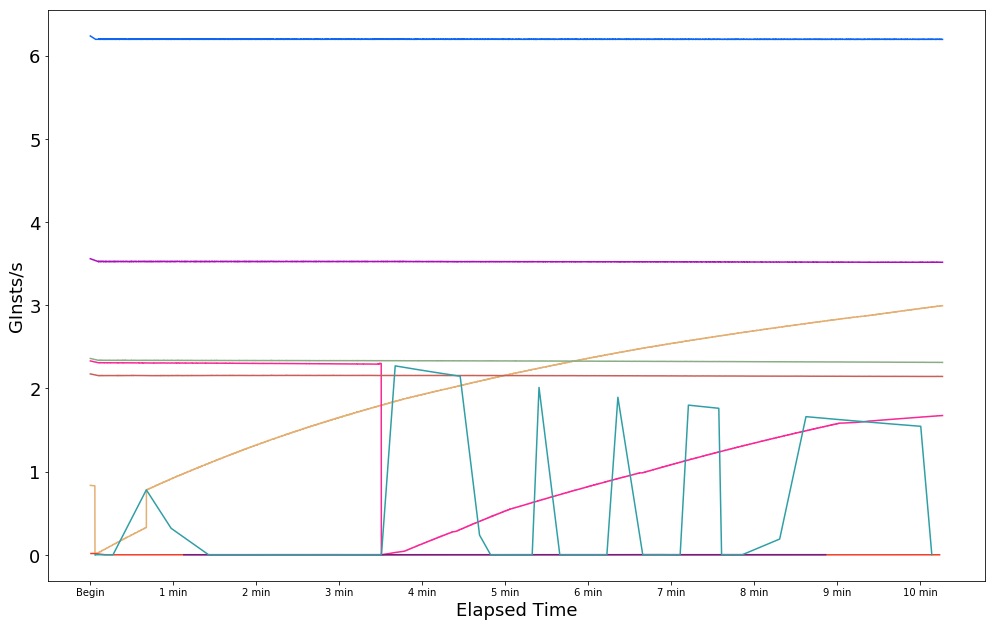

In [11]:
# Each call of this function plots a line, associated to a PID
def plot_pid_time(inst_data, pid, color):    
    x = []
    y = []
    pid_data = inst_data.filter(lambda x: x["PID"] == pid) # Filters data for desired PID

    for r in pid_data.collect():
        x.append(r["TIME"])
        y.append(r["gis"])
        
    plt.plot(x, y, color)
        
# One line per PID: insts against timestamp
def plot_time(inst_data, plot_legend=True, xtick_data=None):
    axs = plt.gca()

    plt.gcf().set_size_inches(16.8, 10.5)
    #axs.set_yscale("log")
    axs.set_xlabel("Elapsed Time", fontsize=18)
    axs.set_ylabel("GInsts/s", fontsize=18)
    
    if xtick_data is not None:
        axs.set_xticks(xtick_data["values"])
        axs.set_xticklabels(xtick_data["labels"])
    
    # Bigger y ticks
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    
    MAX_PIDS = 15 # A lot of lines would make the graphic a mess
    
    p_map = associate_colors_to_pids(pids[:MAX_PIDS], tol = 100)
        
    legend = []
    
    # Loop for main calls
    for i, (pid, col) in enumerate(p_map.iteritems()):
        if i == MAX_PIDS:
            break
        plot_pid_time(inst_data, pid, col)
        legend.append(mpatches.Patch(color=col, label=pid)) # For legend plotting
    
    if plot_legend:
        plt.legend(handles=legend, loc="upper left")
        
    # Avoids some strange figures due to rare peaks
    ylims = list(axs.get_ylim())
    ylims[1] = min(ylims[1], ROOFS[0]["max_ginsts"])
    axs.set_ylim(ylims)
    
    # Shows everything
    plt.show()
    
    if AS_A_SERVER_SCRIPT:
        plt.savefig("timeplot.png", bbox_inches="tight")
        plt.gcf().clear()

plot_time(time_incr, plot_legend = False, xtick_data = custom_xtick_data)

## RM evolution for one TID

In [12]:
# From: http://bsou.io/posts/color-gradients-with-python
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
    colors in RGB and hex form for use in a graphing function
    defined later on '''
    return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
        "r":[RGB[0] for RGB in gradient],
        "g":[RGB[1] for RGB in gradient],
        "b":[RGB[2] for RGB in gradient]}

def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
    ''' returns a gradient list of (n) colors between
    two hex colors. start_hex and finish_hex
    should be the full six-digit color string,
    inlcuding the number sign ("#FFFFFF") '''
    # Starting and ending colors in RGB form
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(finish_hex)
    # Initialize a list of the output colors with the starting color
    RGB_list = [s]
    # Calculate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
            for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)

    return color_dict(RGB_list)

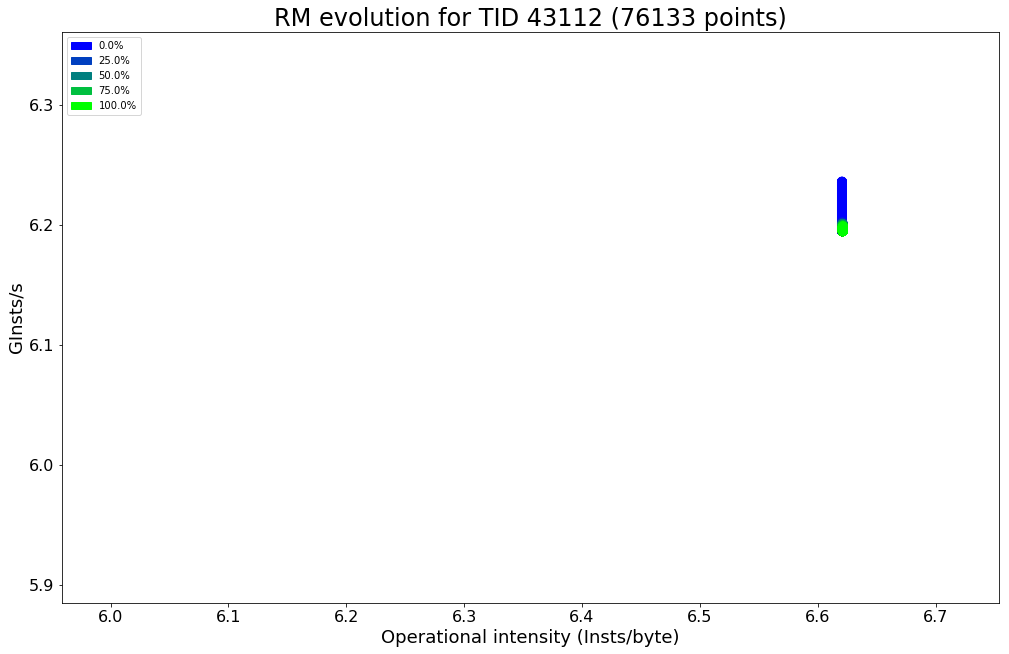

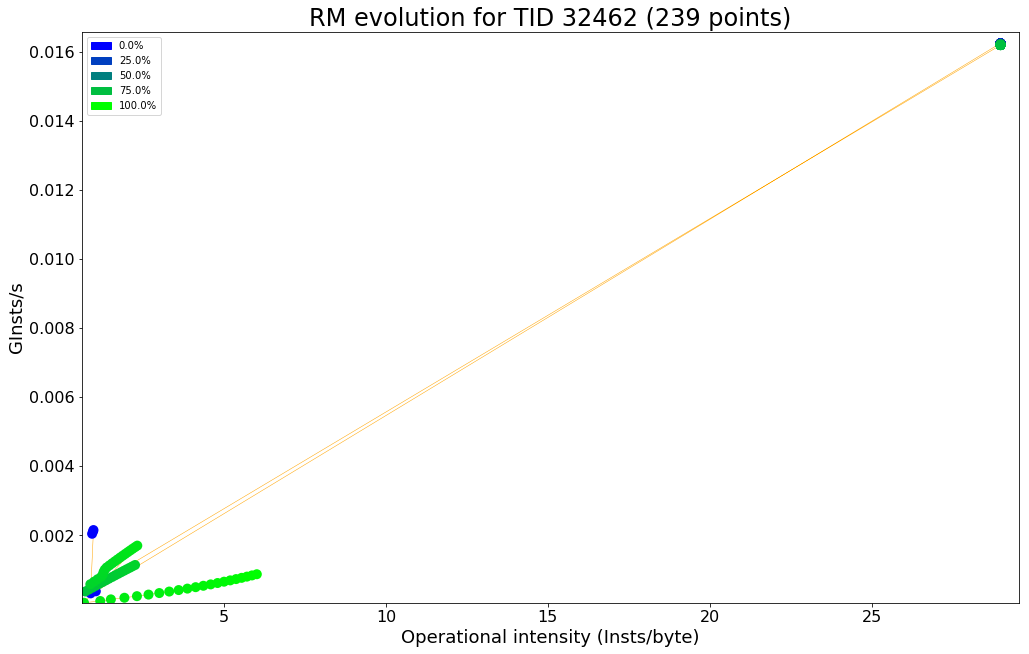

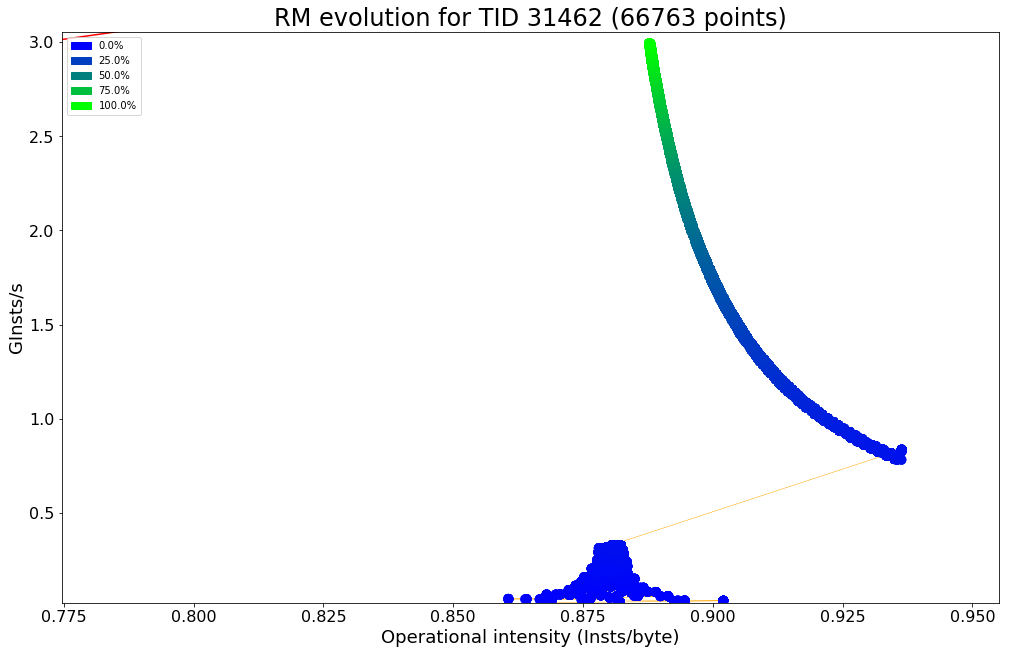

In [13]:
def plot_rm_ev(inst_data, tid, legend=False, log_scale=[], xmin=None, ymin=None, xmax=None, ymax=None):
    x = []
    y = []
    tid_data = inst_data.filter(lambda x: x["TID"] == tid) # Filters data for desired TID

    for r in tid_data.collect():
        x.append(r["oi"])
        y.append(r["gis"])
        
    num_of_points = len(x)
    
    # No pointless graphics
    if num_of_points < 6:
        return 0
    
    # Gets "number of points" colors that are a gradient from blue to green
    cs = linear_gradient("#0000ff", "#00ff00", num_of_points)["hex"]
    
    axs = plt.gca()
    plt.gcf().set_size_inches(16.8, 10.5)
    #axs.set_yscale("log")
    axs.set_xlabel("Operational intensity (Insts/byte)", fontsize=18)
    axs.set_ylabel("GInsts/s", fontsize=18)
    
    # Bigger ticks
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
        
    if "y" in log_scale:
        axs.set_yscale("log", basey=2)
    if "x" in log_scale:
        axs.set_xscale("log", basex=2)
        
    draw_roofs()
    
    # Main call: points as a scatter and a additional plot for a line that joins them
    plt.scatter(x, y, c = cs, s = 100, linewidth = 0, edgecolor="", zorder=2)
    plt.plot(x, y, "orange", linewidth = 0.5, zorder=1)

    if xmin is None:
        xmin = 0.9*min(x)
    if xmax is None:
        xmax = 1.02*max(x)
    if ymin is None:
        ymin = 0.95*min(y)
    if ymax is None:
        ymax = 1.02*max(y)
    axs.set_xlim(xmin, xmax)
    axs.set_ylim(ymin, ymax)
    
    # Optional legend plotting
    if legend:
        # Custom amount of legend entries
        num = 5
        facs = num - 1
        fac_len = (num_of_points-1) / float(facs)
        fac_100 = 100 / float(facs)
        indexes = [int(i*fac_len) for i in range(num)]
        legend_labels = [str(i*fac_100) + "%" for i in range(num)]

        legend = [mpatches.Patch(color=cs[big], label=legend_labels[little]) for little, big in enumerate(indexes)]
        plt.legend(handles=legend, loc="upper left")
        
    plt.title("RM evolution for TID " + tid + " (" + str(num_of_points) + " points)", fontsize=24)
    
    # Shows everything
    plt.show()
    
    if AS_A_SERVER_SCRIPT:
        plt.savefig("RM_ev_TID_" + tid + ".png", bbox_inches="tight")
        plt.gcf().clear()
    
    return 1

generated = 0
for tid in tids:
    generated += plot_rm_ev(data_incr, tid, legend=True)
    if generated == MAX_RM_EVS_FIGURES: # We don't need ALL the graphics
        break

# Clustering

Let's use MLlib to do some thread clustering using aggregated data. MLlib does not incorporate metric functions for clustering. So, the **silhouette coefficient** will be calculated manually. This value is associated to a datum, and it is defined in the following way:

* For a datum `i`, let `a`<sub>`i`</sub> be the average distance from `i` to all elements that are in the same cluster as `i`.
* Calculate, for each cluster different from the one `i` belongs to, the average distance from `i` to all elements that are in the cluster. Then, let `b`<sub>`i`</sub> be the minimum of those values.
* Finally, the silhouette coefficient, `s`<sub>`i`</sub>, for datum `i`, is defined as:

<span style="font-size: 1.5em;">$s_i = \frac{b_i - a_i}{max(b_i,a_i)}$</span>


For different `k` values, we will choose the best partition as the one with the highest mean (for all datum) silhouette value.

First, we need to calculate a distance matrix that indicates the distance (Mahalanobis for this case) from one point to any other. Then, we get information about the cluster assigned to each datum. Finally, we apply the formula described above.

In [14]:
from math import sqrt
import numpy as np

# Calculates distance matrix using Mahalanobis
def get_distance_matrix(rows, cov_m = [[1,0],[0,1]]):
    cov_inv = np.linalg.inv(cov_m)

    dist_m = []
    for v1 in rows:
        row = []
        for v2 in rows:            
            sublist = map(lambda p1, p2: (p1-p2), v1, v2)
            
            m1 = np.matrix(sublist)
            m2 = np.matrix(cov_inv)
            m3 = np.matrix(sublist).transpose()
            m12 = np.dot(m1, m2)
            dist = sqrt(np.dot(m12, m3))
            
            row.append(dist)
        dist_m.append(row)
        
    return dist_m

# Associates cluster to rows
def get_data_cluster(df, model):
    rows = model.transform(df).collect()
    data_cluster = [r.prediction for r in rows]
    return data_cluster

# Calculates silhouete index with above data
def calc_sil(data_cluster, dist_m, index_elem, k):
    clus_elem = data_cluster[index_elem]

    ## a
    elems_in_same_cluster = [idx for idx,cl in enumerate(data_cluster) if cl == clus_elem]
    l = []

    # Concatenates distances from elements in the same cluster
    for el in elems_in_same_cluster:
        if el == index_elem:
            continue

        l.append(dist_m[el][index_elem])

    if not l:
        return 0 # As tested in R, "s" seems to be directly 0 in these cases
    else:
        a = np.mean(l)

    ## b
    means = []

    # For each cluster different from the one the point belongs to
    for cluster in range(k):
        if cluster == clus_elem:
            continue

        elems_in_cluster = [idx for idx,cl in enumerate(data_cluster) if cl == cluster]
        l = []

        # Concatenates distances from elements in the cluster
        for el in elems_in_cluster:
            l.append(dist_m[el][index_elem])
        means.append(np.mean(l))

    b = min(means)

    ## s
    s = (b-a)/max(a,b)
    return s

Best K = 2


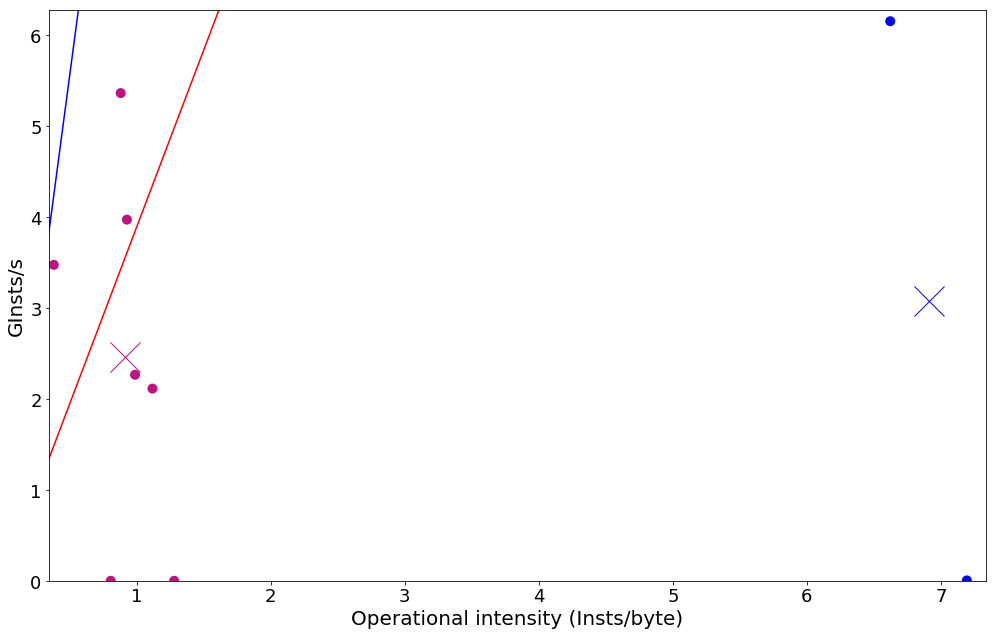

In [15]:
if USING_CLUSTER:
    from pyspark.mllib.linalg import Vectors # Cluster uses Spark 1.6
else:
    from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans

# We adapt data to clustering input
data = [(Vectors.dense(v),) for v in vectors]
newdf = spark.createDataFrame(data, ["features"])
newdf.cache()

dist_m = get_distance_matrix(vectors)

max_k = 9

## For each k value...
sil_means = [0, 0] # No value for k = [0, 1]
for k_val in range(2, max_k+1):
    model = KMeans(k=k_val, seed = 1).fit(newdf) # Trains model
    data_cluster =  get_data_cluster(newdf, model) # Associates cluster to rows

    # Calculates mean silhouete value for that k value. Then, we will keep the k value that gives the maximum one
    sils = []
    for i in range(len(vectors)):
        sil = calc_sil(data_cluster, dist_m, i, k_val)
        sils.append(sil)
    sil_mean = np.mean(sils)
    sil_means.append(sil_mean)
    
    if PRINT_ALL_KS:
        color_map = associate_colors_to_pids(range(k_val))
        data_color = [color_map[d] for d in data_cluster]
        #cs = [plt.Circle((ctr[1], ctr[0]), 0.3, color=color_map[i], alpha=0.2, edgecolor="#000000", linewidth=5) for i, ctr in enumerate(model.clusterCenters())]
        cs = [(ctr[1], ctr[0], color_map[i]) for i, ctr in enumerate(model.clusterCenters())]
        plot_data(ois, giss, colors=data_color, marks=cs, filename = "clusK" + str(k_val) + ".png")
    
min_sil_mean = max(sil_means)
best_k = sil_means.index(min_sil_mean)
print "Best K =", best_k

if not PRINT_ALL_KS:
    # Only plots best K model
    model = KMeans(k=best_k, seed = 1).fit(newdf)
    data_cluster = get_data_cluster(newdf, model)
    color_map = associate_colors_to_pids(range(best_k))
    data_color = [color_map[d] for d in data_cluster]
    #cs = [plt.Circle((ctr[1], ctr[0]), 0.3, color=color_map[i], alpha=0.2, edgecolor="#000000", linewidth=5) for i, ctr in enumerate(model.clusterCenters())]
    cs = [(ctr[1], ctr[0], color_map[i]) for i, ctr in enumerate(model.clusterCenters())]
    plot_data(ois, giss, colors=data_color, marks=cs, filename = "clusK" + str(best_k) + ".png")
